# Lifespans of notable people

This noteboook uses survival analysis to understand how the lifespans of
"notable people" have varied over the centuries, and between notable
women and notable men.

The data are available here:

http://science.sciencemag.org/content/suppl/2014/07/30/345.6196.558.DC1

This is a very unusual population from a statistical perspective.
Much of the data comes from people who have a Wikipedia page.  The
reasons why someone may be deemed "notable" vary over time, and by
gender.

Import the modules we will be using below.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Run the next block once (by changing False to True) to get a csv version
of the data set.

In [2]:
if False:
    df = pd.read_excel("../data/SchichDataS1_FB.xlsx")
    df = df[["PrsLabel", "BYear", "DYear", "Gender"]]
    df.to_csv("../data/schich.csv.gz", index=None, compression="gzip")

Load the data.

In [3]:
df = pd.read_csv("../data/schich.csv.gz")
df = df.dropna()

Create a variable that contains the lifespan for each person in the
dataset.  This only includes people who have known birth years and
death years.  Note that selecting the people who have already died
will generally introduce bias.

In [4]:
df["lifespan"] = df.DYear - df.BYear

There are too few people with genders other than female/male to
analyze here.

In [5]:
df = df.loc[df.Gender.isin(["Female", "Male"])]

Some survival analysis methods have trouble with event times that are
equal to 0, so we remove those cases here.

In [6]:
df = df.loc[df.lifespan > 0]

Plot the poduct-limit survival function estimates for females and for
males.

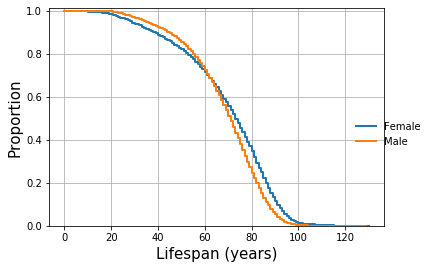

In [7]:
ax = plt.axes()
plt.grid(True)
plt.xlabel("Lifespan (years)", size=15)
plt.ylabel("Proportion", size=15)
for sex in "Female", "Male":
    ii = df.Gender == sex
    s = sm.SurvfuncRight(df.loc[ii, "lifespan"], np.ones(ii.sum()), title=sex)
    s.plot(ax=ax)

# Create a legend
ha, lb = ax.get_legend_handles_labels()
ha = [ha[0], ha[2]] # Optional, hide points from legend
lb = [lb[0], lb[2]]
leg = plt.figlegend(ha, lb, loc="center right")
leg.draw_frame(False)

## Hazard function estimates for females and males

The hazard function is the derivative of -log(S(t)), where S(t) is the
survival function.  Below we will create hazard function estimates for
females and for males by taking the numerical derivative of the log survival
function.  This derivative is very crude, so the hazard estimates based
on it will be quite variable.

In [8]:
def hazard(sf):
    tm = s.surv_times
    pr = s.surv_prob
    ii = (pr > 0)
    tm = tm[ii]
    pr = pr[ii]
    lpr = np.log(pr)
    return tm[0:-1], -np.diff(lpr) / np.diff(tm)

Plot the hazard functions

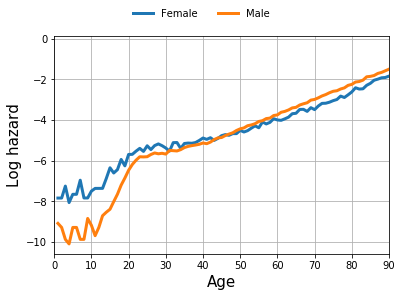

In [9]:
plt.grid(True)
for sex in "Female", "Male":
    ii = df.Gender == sex
    s = sm.SurvfuncRight(df.loc[ii, "lifespan"], np.ones(ii.sum()), title=sex)
    tm, hz = hazard(s)
    plt.plot(tm, np.log(hz), lw=3, label=sex)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center", ncol=2)
leg.draw_frame(False)
plt.xlabel("Age", size=15)
plt.ylabel("Log hazard", size=15)
_ = plt.xlim(0, 90)

Plot survival function estimates by era

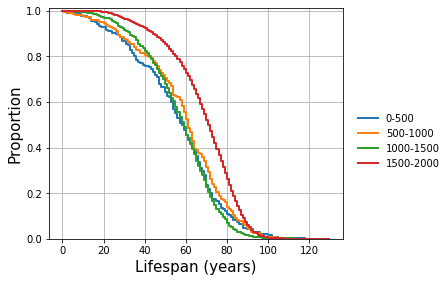

In [10]:
ax = plt.axes([0.08, 0.1, 0.68, 0.8])
plt.grid(True)
plt.xlabel("Lifespan (years)", size=15)
plt.ylabel("Proportion", size=15)
for byear in np.arange(0, 2000, 500):
    ii = (df.BYear >= byear) & (df.BYear < byear + 500)
    s = sm.SurvfuncRight(df.loc[ii, "lifespan"], np.ones(ii.sum()),
                         title="%d-%d" % (byear, byear+500))
    s.plot(ax=ax)

# Create a legend
ha, lb = ax.get_legend_handles_labels()
ha = [ha[i] for i in range(0, len(ha), 2)] # Optional, hide points from legend
lb = [lb[i] for i in range(0, len(lb), 2)]
leg = plt.figlegend(ha, lb, loc="center right")
_ = leg.draw_frame(False)

Plot hazard function estimates by era

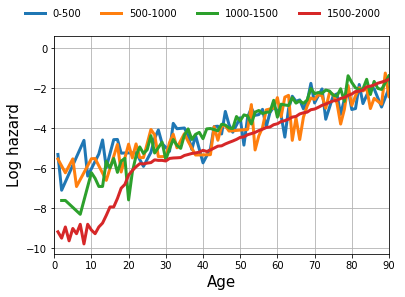

In [11]:
plt.grid(True)
for byear in np.arange(0, 2000, 500):
    ii = (df.BYear >= byear) & (df.BYear < byear + 500)
    s = sm.SurvfuncRight(df.loc[ii, "lifespan"], np.ones(ii.sum()))
    tm, hz = hazard(s)
    plt.plot(tm, np.log(hz), lw=3, label="%d-%d" % (byear, byear+500))
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center", ncol=4)
leg.draw_frame(False)
plt.xlabel("Age", size=15)
plt.ylabel("Log hazard", size=15)
_ = plt.xlim(0, 90)

## Survival regression analyses

First we fit a linear model for lifespan, to see how
the expected lifespan varies based on the year of
birth, and how it may differ between women and men.

In [12]:
fml = "lifespan ~ bs(BYear, 5) * Gender"
dx = df.loc[(df.BYear >= 500) & (df.BYear <= 1900), :]
model1 = sm.OLS.from_formula(fml, data=dx)
result1 = model1.fit()

The function below plots the fitted mean lifespans for women
and men based on the linear model.

In [13]:
def model_plot(result, ylabel):
    x = np.linspace(500, 1900).tolist()
    dr = dict({"BYear": x + x, "Gender": ["Female"]*len(x) + ["Male"]*len(x)})
    dr = pd.DataFrame(dr)
    pr = result.predict(exog=dr)
    if hasattr(pr, "predicted_values"):
        pr = pr.predicted_values
    plt.grid(True)
    plt.plot(x, pr[0:len(x)], '-', label="Female", color='purple')
    plt.plot(x, pr[len(x):], '-', label="Male", color='orange')
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "upper center", ncol=2)
    leg.draw_frame(False)
    plt.xlabel("Birth year")
    plt.ylabel(ylabel)

Use the function defined above to plot the mean lifespans.

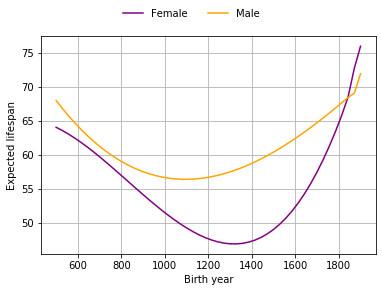

In [14]:
model_plot(result1, "Expected lifespan")

The scatterplot below shows the potential problem of analyzing these
duration data with standard (non-survival) regression methods.  The
consequences of censoring are evident on the right side of the plot.

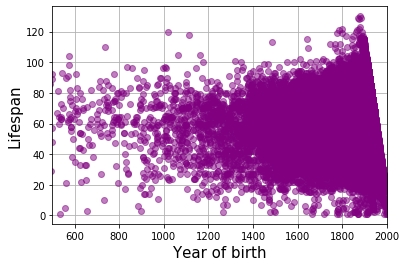

In [15]:
left = 500
plt.axes()
plt.grid(True)
plt.plot(df.BYear, df.lifespan, 'o', color='purple', alpha=0.5,
         rasterized=True)
plt.xlabel("Year of birth", size=15)
plt.ylabel("Lifespan", size=15)
_ = plt.xlim(left, 2000)

Next we fit a model for log lifespan.

In [16]:
fml = "I(np.log(lifespan)) ~ bs(BYear, 5) * Gender"
model2 = sm.OLS.from_formula(fml, data=df)
result2 = model2.fit()

Plot the expected log lifespans.

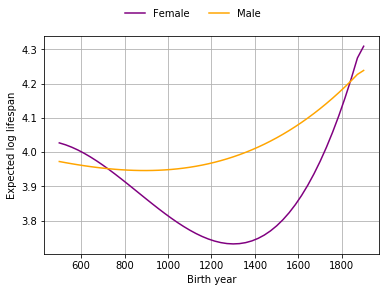

In [17]:
model_plot(result2, "Expected log lifespan")

Below we fit a proportional hazards regression model.

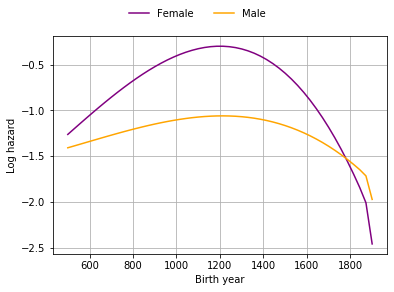

In [18]:
fml = "lifespan ~ bs(BYear, 4) : Gender"
dx = df.loc[df.BYear <= 1900, :]
model3 = sm.PHReg.from_formula(fml, data=dx)
result3 = model3.fit()

model_plot(result3, "Log hazard")

Plot the baseline hazard function

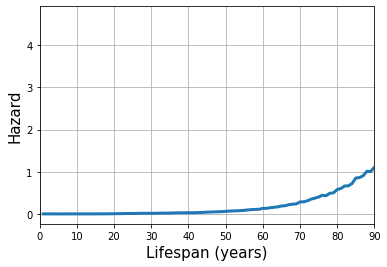

In [19]:
bhaz = result3.baseline_cumulative_hazard[0]
x = bhaz[0]
y = bhaz[1]
haz = np.diff(y, 1) / np.diff(x, 1)
plt.clf()
plt.grid(True)
plt.plot(x[0:-1], haz, lw=3)
plt.xlim(0, 90)
plt.xlabel("Lifespan (years)", size=15)
_ = plt.ylabel("Hazard", size=15)